# Mixed precision timeseries for precipitation

In [53]:
#THIS IS THE SAME AS NOTEBOOK 1a BUT MODIFIED TO JUST PROCESS A SIGNLE INPUT DIRECTORY


import glob
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys

def get_global_weights():
    
    # Get the latitude weights from a special location
    
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude




def average_over_space(x,weights,use_weights):
    
    if use_weights:
        return x.weighted(weights).mean(("longitude", "latitude")) # Get the average global temperature at each timestep.
    else:
        return x.mean(("longitude", "latitude"))


def process_nc_file(f,weights,use_weights,correct_latitude_values):
    

    #Open dataset
    ds = xr.open_dataset(f)
    
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
        
    #Get precipitations
    LSP = ds.large_scale_precipitation * (6*60*60) / 1000 #mm / 6h
    CVP = ds.convective_precipitation  * (6*60*60) / 1000 #mm / 6h              

    if LSP.shape != (365, 48, 96):
        return False #Exit function and don't use this one
 
    #Average over space
    LSP_global_av = average_over_space(LSP,weights,use_weights) #365 points
    CVP_global_av = average_over_space(CVP,weights,use_weights) #365 points
    precipitation = LSP_global_av + CVP_global_av 
    
    #Average over time
    global_annual_average_precip = float(precipitation.mean().values)
    ds.close()
    return global_annual_average_precip
    
    



def process_ensemble_members(m,use_weights):
    
        
    print ('--------------------------')
    print ('Processing single directory ',m)
    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    weights = np.cos(np.deg2rad(correct_latitude_values))
    weights.name = "weights"
    
    
    #Get the different available precisions in this m-directory
    root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_{m}/'
    precision_directories = sorted(glob.glob(root+'*'))
    
    dfs = [] 
    for p in precision_directories:
        print(p)
        
        #Read the float precision from the filename
        precision = p.split('/')[-1].split('_')[2]
        rounding = p.split('/')[-1].split('_')[3]
        pid = precision+'_'+rounding
        print(pid,p)
    
        nc_files = sorted(glob.glob(p+'/**/*model_output*.nc',recursive=True))

        precip_m = []
        for n in tqdm(nc_files):
            precip = process_nc_file(n,weights,use_weights,correct_latitude_values)
            if precip is not False:   #False if the shape isnt correct
                precip_m.append(precip)
            
        
        #Make it a pandas df an append to dfs
        data_dictionary = {'time': np.arange(len(precip_m)),
                           'precip': precip_m}
        df = pd.DataFrame(data_dictionary)
        df['precision'] = pid
        dfs.append(df)
        
        
    #Now do some IO
   
    df = pd.concat(dfs).reset_index(drop=True)
    
    if use_weights:
        uw = 'weighted'
    else:
        uw = 'unweighted'
    
    
    fname = f'data/{m}_precip_timeseries_{uw}_mixedprecision.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df,fname)
        

# Process raw data mixed precision solutions

In [ ]:
process_ensemble_members('m5',use_weights=True)
process_ensemble_members('m6',use_weights=True)
process_ensemble_members('m7',use_weights=True)
process_ensemble_members('m8',use_weights=True)
process_ensemble_members('m9',use_weights=True)

--------------------------
Processing single directory  m5
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m5/speedyone100yr_L2_10_RNcpl_m5
10_RNcpl /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m5/speedyone100yr_L2_10_RNcpl_m5


100%|██████████| 33/33 [01:17<00:00,  2.36s/it]


ALl iterations completed. Now saving to file: data/m5_precip_timeseries_weighted_mixedprecision.pkl
--------------------------
Processing single directory  m6
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m6/speedyone100yr_L2_10_RNcpl_m6
10_RNcpl /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m6/speedyone100yr_L2_10_RNcpl_m6


100%|██████████| 33/33 [01:10<00:00,  2.14s/it]


ALl iterations completed. Now saving to file: data/m6_precip_timeseries_weighted_mixedprecision.pkl
--------------------------
Processing single directory  m7
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m7/speedyone100yr_L2_10_RNcpl_m7
10_RNcpl /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m7/speedyone100yr_L2_10_RNcpl_m7


100%|██████████| 33/33 [01:11<00:00,  2.16s/it]


ALl iterations completed. Now saving to file: data/m7_precip_timeseries_weighted_mixedprecision.pkl
--------------------------
Processing single directory  m8
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m8/speedyone100yr_L2_10_RNcpl_m8
10_RNcpl /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/tmp_m8/speedyone100yr_L2_10_RNcpl_m8


 27%|██▋       | 9/33 [00:19<00:51,  2.14s/it]

# And now load and plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

def round_down(num, divisor):
    return num - (num%divisor)


def calculate_residuals(df,column):
    df_truth = df.query('precision == "52_RN" ')                       # Get a ground truth that all others will be compared against.
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) # ...and all the others
    df_join = pd.merge(df_rest,df_truth,
                       how='left',on='time',  
                       suffixes=(None, '_truth'))                       # Join

    
    df_join['MBE'] = df_join[column] - df_join[column+'_truth']        # Residuals 1
    df_join['MAE'] = abs(df_join[column] - df_join[column+'_truth'])   # Residuals 2
    
    
    print ('Average errors over all years:')
    display(df_join.groupby(by=["precision"]).mean()) 
    
    return df_join
    
    
def plot_timeseries(df,savefig,decadal_average):
    
    #Set up plot figure
    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    #Part A: TIMESERIES
    p = sns.lineplot(data=df, 
                     x="time", y='precip',
                     ax=ax1,
                     hue="precision",style="precision",markers=True) 
    

    #Part B: RESIDUALS
    df_residual = calculate_residuals(df,'precip')

    if decadal_average:
        df_decadal = df_residual.copy()
        df_decadal['decade'] = df_decadal['time'].apply(lambda x : round_down(x,10))  # Round the time down to nearest 10
        df_decadal.groupby(['decade','precision']).mean()                             # Group by
        df_decadal['decade'] = df_decadal['decade'] + 5                               # Shift point to decade centre
        
        
        df_ax2 = df_decadal
        ax2_xaxis = 'decade'
                
    else: 
        df_ax2 = df_residual
        ax2_xaxis = 'time'
        
        
    q = sns.lineplot(data=df_ax2, 
                     x=ax2_xaxis, y='MBE',
                     ax=ax2,
                     hue="precision",style="precision",markers=True,legend=True) 
    
    
    
    #Part C: CONFIG
    plt.subplots_adjust(wspace=0.1, hspace=0)
    ax1.set_ylabel("Global Mean Precipitation (mm / 6h)")
    ax2.set_ylabel("Mean Bias Error (mm / 6h)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    ax1.set_title(None)
    
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    #Other config
    ax1.legend().set_title(None)
    
    
    
    
    
    
    
    
    

In [ ]:
#NEW FILES

precip_timeseries_data = sorted(glob.glob('data/m*_precip_timeseries_weighted_mixedprecision.pkl'))
precip_dfs_new = []
for d in precip_timeseries_data:
    df = pd.read_pickle(d)
    precip_dfs_new.append(df)

precip_ensemble_new = pd.concat(precip_dfs_new).reset_index()

In [ ]:
#ORIGINAL FILES
precip_timeseries_data = sorted(glob.glob('data/m*_precip_timeseries_weighted.pkl'))

precip_dfs_og = []
for d in precip_timeseries_data:
    df = pd.read_pickle(d)
    precip_dfs_og.append(df)
    
precip_ensemble_og = pd.concat(precip_dfs_og).reset_index()

In [47]:
precip_ensemble = pd.concat([precip_ensemble_og,precip_ensemble_new]).reset_index()

In [ ]:
plot_timeseries(precip_ensemble,savefig=None,decadal_average=False)


---

Average errors over all years:


,index,time,precip,index_truth,precip_truth,MBE,MAE
precision,,,,,,,
10_RN,9.5,9.5,0.747706,309.5,0.752739,-0.005033,0.005646
10_RNcpl,22.5,4.5,0.743723,304.5,0.745363,-0.001640,0.002584
10_RNcpl2,8.5,8.5,0.749222,308.5,0.751292,-0.002070,0.002836
10_RNstloop5,32.5,4.5,0.739557,304.5,0.745363,-0.005806,0.005806
10_SR,109.5,9.5,0.754611,309.5,0.752739,0.001872,0.003526
23_RN,209.5,9.5,0.751708,309.5,0.752739,-0.001031,0.003806


,index,time,precip,precision
0,0,0,0.722066,10_RN
1,1,1,0.738474,10_RN
2,2,2,0.735509,10_RN
3,3,3,0.740993,10_RN
4,4,4,0.743358,10_RN
...,...,...,...,...
113,33,5,0.743114,10_RNstloop5
114,34,6,0.750632,10_RNstloop5
115,35,7,0.748305,10_RNstloop5
116,36,8,0.747356,10_RNstloop5


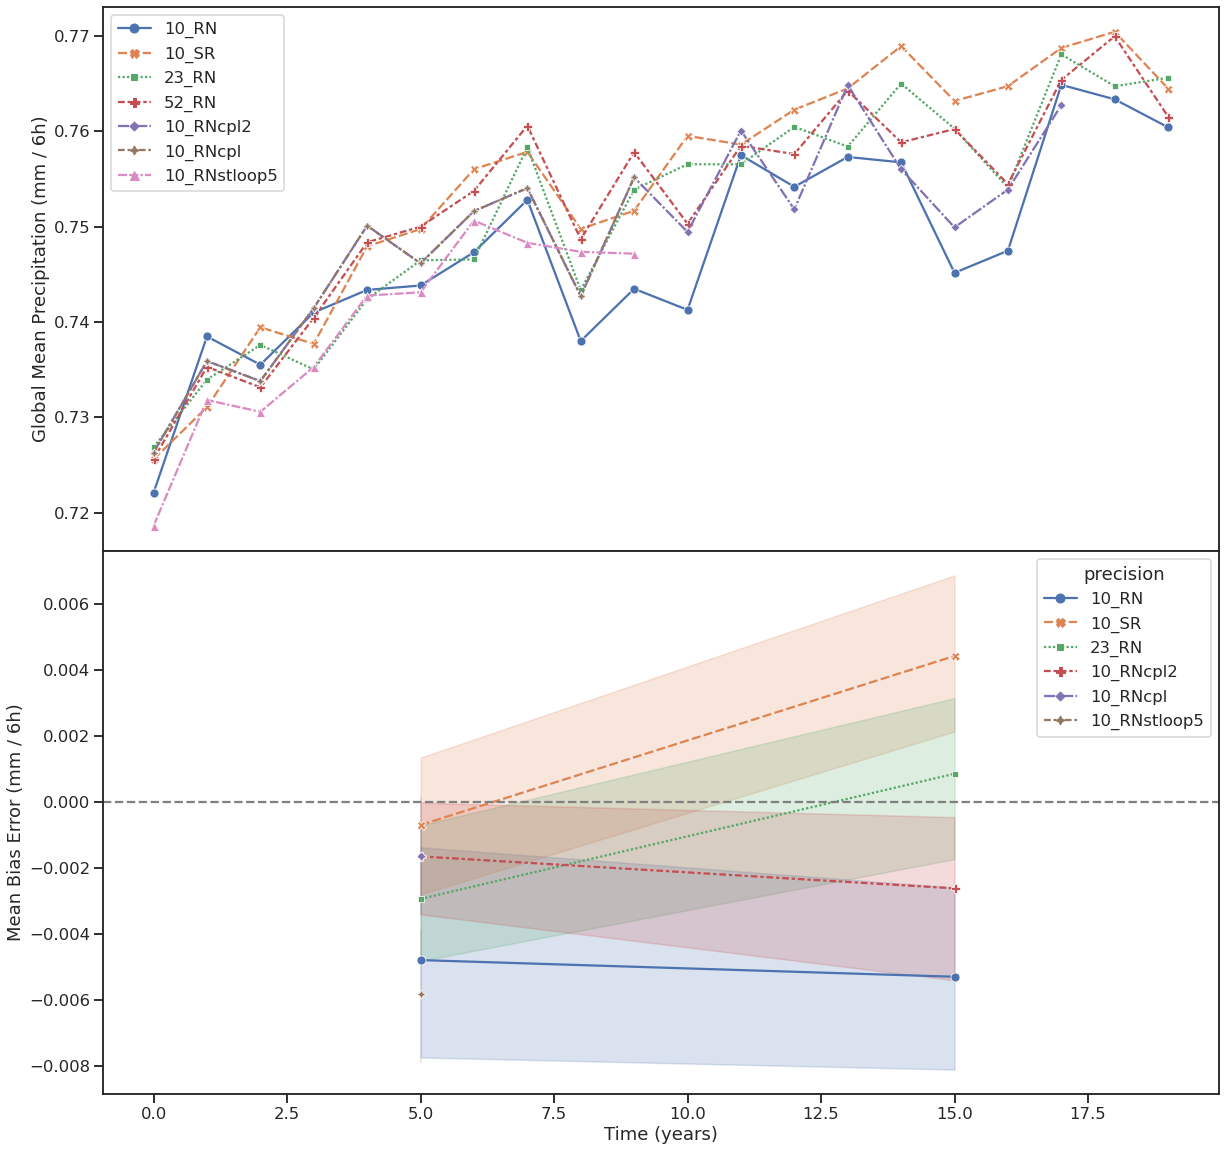

In [21]:
df_og = pd.read_pickle(original_file)
df10 = df_og.query('time < 20')
df_mp = pd.read_pickle(mp_file)
dfplot = pd.concat([df10,df_mp])
plot_timeseries(dfplot.reset_index(),savefig=None,decadal_average=True)
display(dfplot.reset_index())
